In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("patient_priority.csv")

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6962 entries, 0 to 6961
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                6962 non-null   int64  
 1   gender             6961 non-null   float64
 2   chest pain type    6962 non-null   int64  
 3   blood pressure     6962 non-null   int64  
 4   cholesterol        6962 non-null   int64  
 5   max heart rate     6962 non-null   int64  
 6   exercise angina    6962 non-null   int64  
 7   plasma glucose     6962 non-null   float64
 8   skin_thickness     6962 non-null   int64  
 9   insulin            6962 non-null   int64  
 10  bmi                6962 non-null   float64
 11  diabetes_pedigree  6962 non-null   float64
 12  hypertension       6962 non-null   int64  
 13  heart_disease      6962 non-null   int64  
 14  Residence_type     6962 non-null   object 
 15  smoking_status     6962 non-null   object 
 16  triage             6552 

In [2]:
# Drop rows where target variable 'triage' is missing
df = df.dropna(subset=['triage'])

# Impute numeric features with median
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.median()))

# Impute categorical features with mode
cat_cols = df.select_dtypes(include=['object']).columns
df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0]))

In [3]:

print(f"Duplicates found: {df.duplicated().sum()}")
df = df.drop_duplicates()

Duplicates found: 0


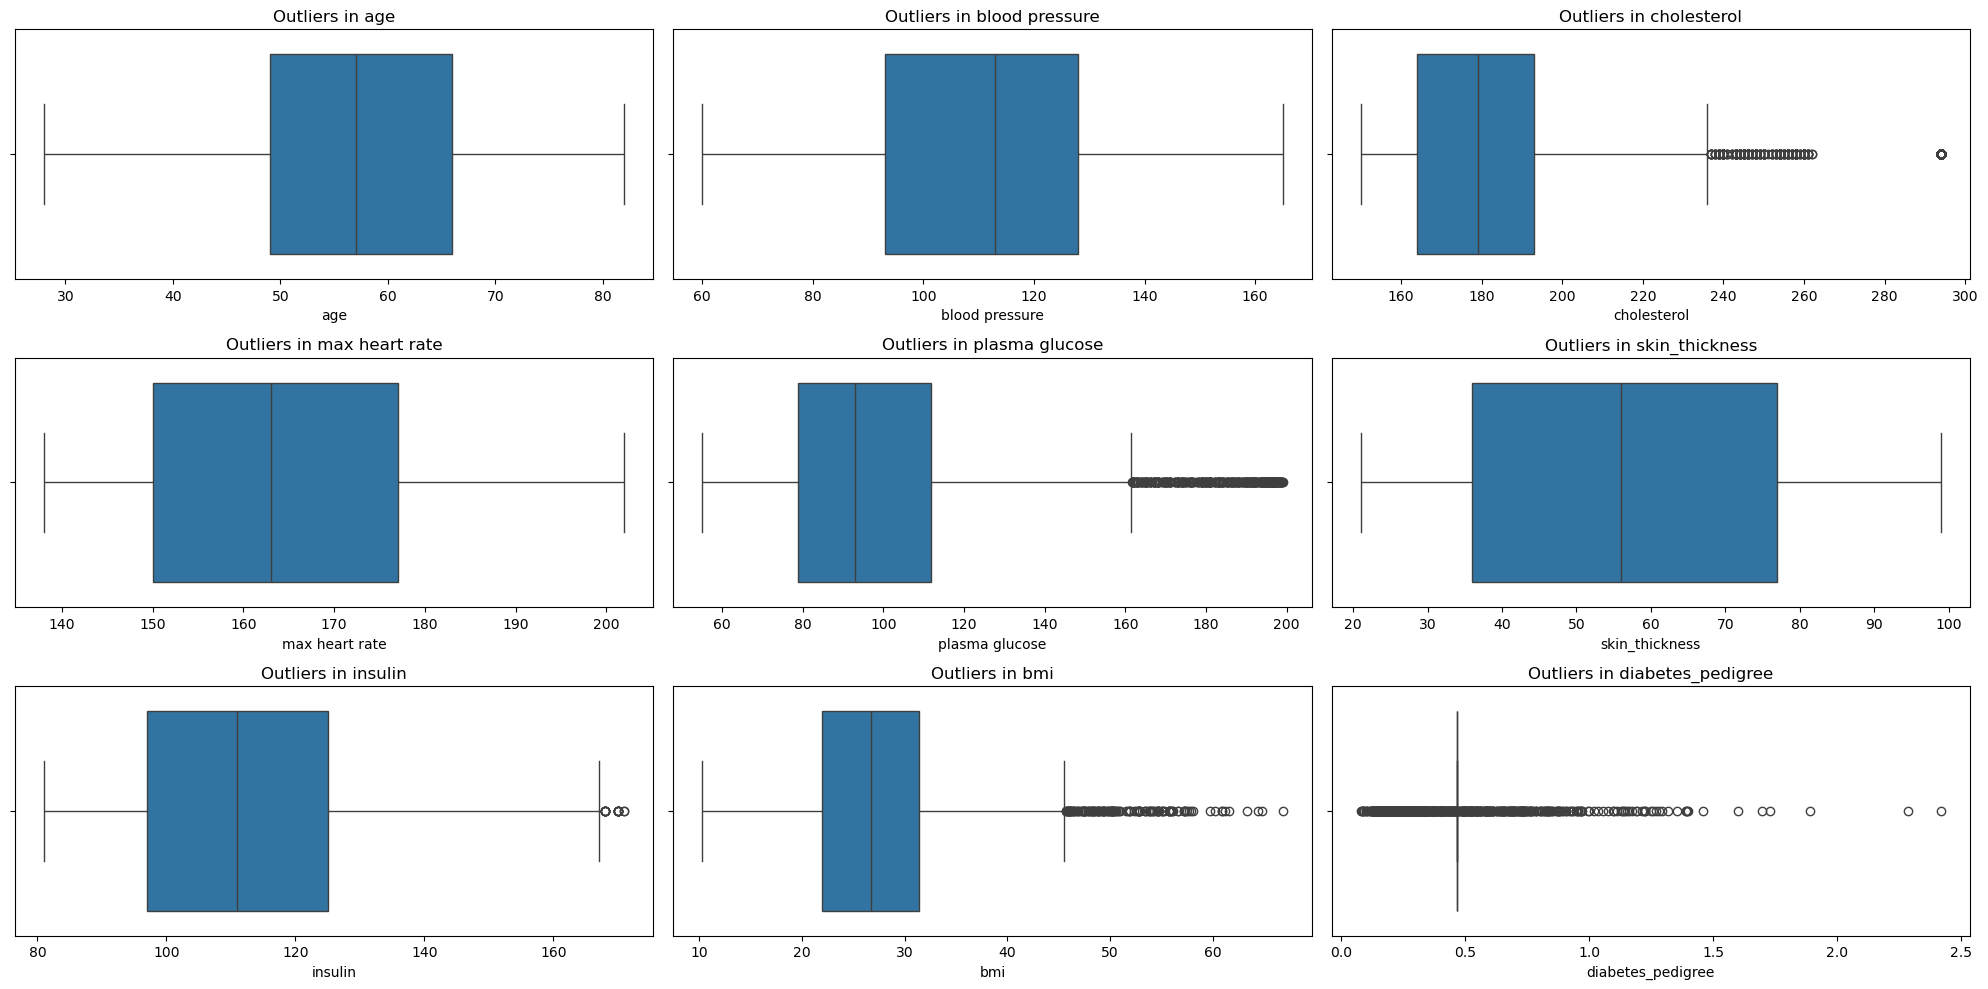

In [4]:
num_cols = ['age', 'blood pressure', 'cholesterol', 'max heart rate', 
            'plasma glucose', 'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree']

plt.figure(figsize=(20, 10))
for i, col in enumerate(num_cols):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=df[col])
    plt.title(f"Outliers in {col}")
plt.tight_layout()
plt.show()

In [5]:
# Encode specified categorical variables
df = pd.get_dummies(df, columns=['Residence_type', 'smoking_status', 'triage'], drop_first=False)

In [6]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Check if 'triage_' columns exist (they may have already been dropped)
if any('triage_' in col for col in df.columns):
    # Encode 'triage' back to single column (assumes previous one-hot encoding was done for EDA)
    df['triage'] = df[[col for col in df.columns if 'triage_' in col]].idxmax(axis=1)
    df['triage'] = df['triage'].str.replace('triage_', '')
    # Drop previous one-hot 'triage' columns
    df = df.drop(columns=[col for col in df.columns if 'triage_' in col])

# Encode target to numeric
le = LabelEncoder()
df['triage'] = le.fit_transform(df['triage'])

# Separate features and target
X = df.drop(columns=['triage'])
y = df['triage']

# Print the number of cases in each triage level before SMOTE
print("Before SMOTE:")
print(y.value_counts())

# Resample using SMOTE
sm = SMOTE(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)

# Print the number of cases in each triage level after SMOTE
print("After SMOTE:")
print(pd.Series(y_resampled).value_counts())





Before SMOTE:
triage
3    5637
0     440
1     346
2     129
Name: count, dtype: int64
After SMOTE:
triage
3    5637
1    5637
2    5637
0    5637
Name: count, dtype: int64


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import mean_squared_error
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
    print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
print("Random Forest Performance:")
evaluate_model(rf, X_train_scaled, X_test_scaled, y_train, y_test)

Random Forest Performance:
Train R²: 0.9994
Train RMSE: 0.0265
Test R²: 0.9982
Test RMSE: 0.0479


Confusion Matrix:
[[1119    0    0    0]
 [   0 1158    0    0]
 [   0    0 1089    0]
 [   0    7    0 1137]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1119
           1       0.99      1.00      1.00      1158
           2       1.00      1.00      1.00      1089
           3       1.00      0.99      1.00      1144

    accuracy                           1.00      4510
   macro avg       1.00      1.00      1.00      4510
weighted avg       1.00      1.00      1.00      4510



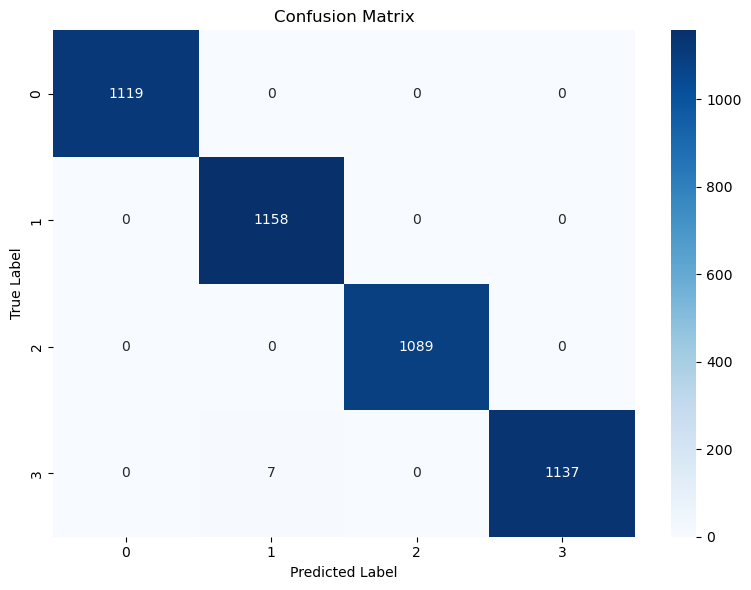

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#Fit initial Random Forest for feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

#Feature Selection based on importance
selector = SelectFromModel(rf, prefit=True, threshold="median")  # Keep features above median importance
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

#Fit new model with selected features
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)
#Evaluate using confusion matrix
y_pred = rf_selected.predict(X_test_selected)

#Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred, labels=rf_selected.classes_)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

#Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_selected.classes_,
            yticklabels=rf_selected.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

import pandas as pd
import numpy as np

# Get feature importances and names
importances = rf.feature_importances_
feature_names = X_train.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)








In [11]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(model, X_train, X_test, y_train, y_test):
    from sklearn.metrics import mean_squared_error
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(f"Train R²: {r2_score(y_train, y_train_pred):.4f}")
    print(f"Train RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.4f}")
    print(f"Test R²: {r2_score(y_test, y_test_pred):.4f}")
    print(f"Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}")

# Convert scaled arrays back to DataFrames with column names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

selected_features = ['plasma glucose', 'blood pressure', 'age', 'bmi', 'chest pain type', 'gender']
X_train_selected = X_train_scaled_df[selected_features]
X_test_selected = X_test_scaled_df[selected_features]
#Fit model using RandomForestRegressor on selected features
rf_selected = RandomForestRegressor(random_state=42)
rf_selected.fit(X_train_selected, y_train)

#Evaluate the selected-features model
print("\nEvaluating Feature-Selected Model:")
evaluate_model(rf_selected, X_train_selected, X_test_selected, y_train, y_test)

#For comparison: Fit model on full feature set
rf_regressor_original = RandomForestRegressor(random_state=42)
rf_regressor_original.fit(X_train_scaled, y_train)

print("\nEvaluating Original Model:")
evaluate_model(rf_regressor_original, X_train_scaled, X_test_scaled, y_train, y_test)






Evaluating Feature-Selected Model:
Train R²: 0.9990
Train RMSE: 0.0358
Test R²: 0.9912
Test RMSE: 0.1052

Evaluating Original Model:
Train R²: 0.9994
Train RMSE: 0.0265
Test R²: 0.9982
Test RMSE: 0.0479



Evaluating Feature-Selected Classifier:

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1119
           1       0.99      1.00      1.00      1158
           2       1.00      1.00      1.00      1089
           3       1.00      0.99      1.00      1144

    accuracy                           1.00      4510
   macro avg       1.00      1.00      1.00      4510
weighted avg       1.00      1.00      1.00      4510

Confusion Matrix:
[[1119    0    0    0]
 [   0 1158    0    0]
 [   0    0 1089    0]
 [   0   11    0 1133]]


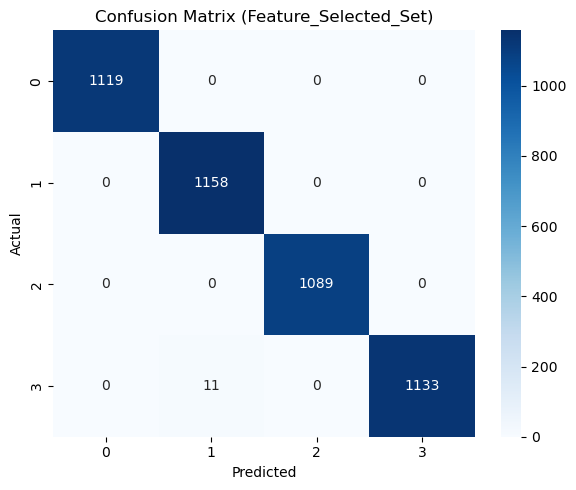


Evaluating Original Classifier:

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1119
           1       1.00      1.00      1.00      1158
           2       1.00      1.00      1.00      1089
           3       1.00      1.00      1.00      1144

    accuracy                           1.00      4510
   macro avg       1.00      1.00      1.00      4510
weighted avg       1.00      1.00      1.00      4510

Confusion Matrix:
[[1119    0    0    0]
 [   0 1155    0    3]
 [   0    0 1089    0]
 [   0    4    0 1140]]


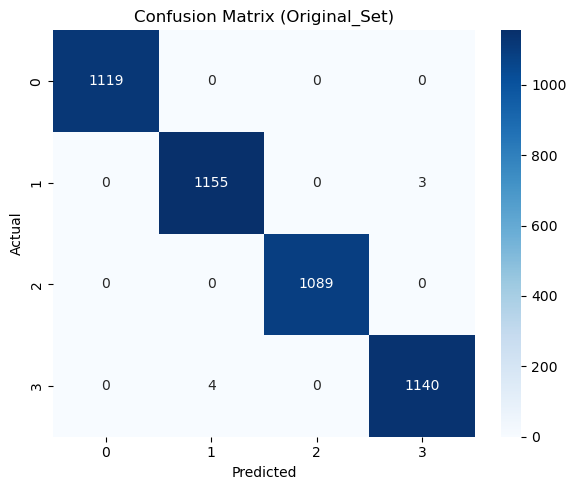

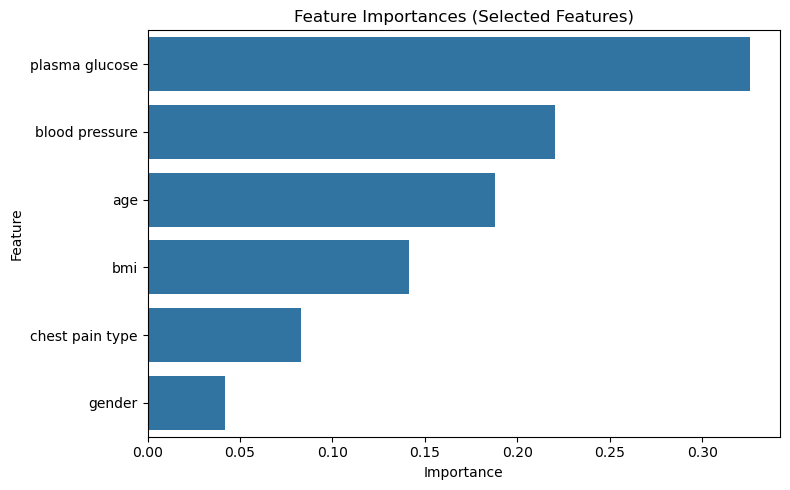

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Updated evaluation function for classification
def evaluate_model(model, X_train, X_test, y_train, y_test, feature_set_name):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("\nClassification Report (Test Set):")
    print(classification_report(y_test, y_test_pred))

    cm = confusion_matrix(y_test, y_test_pred, labels=model.classes_)
    print("Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=model.classes_,
                yticklabels=model.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix ({feature_set_name})")
    plt.tight_layout()
    plt.show()  # Display confusion matrix

# Ensure column names from original data
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# Select the desired subset of features
selected_features = ['plasma glucose', 'blood pressure', 'age', 'bmi', 'chest pain type', 'gender']
X_train_selected = X_train_scaled_df[selected_features]
X_test_selected = X_test_scaled_df[selected_features]

# Fit RandomForestClassifier on selected features
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)

# Evaluate the selected-features model
print("\nEvaluating Feature-Selected Classifier:")
evaluate_model(rf_selected, X_train_selected, X_test_selected, y_train, y_test, "Feature_Selected_Set")

# For comparison: Fit classifier on full feature set
rf_original = RandomForestClassifier(random_state=42)
rf_original.fit(X_train_scaled, y_train)

print("\nEvaluating Original Classifier:")
evaluate_model(rf_original, X_train_scaled, X_test_scaled, y_train, y_test, "Original_Set")

# Feature importance plot for selected features
importances = rf_selected.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(8, 5))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importances (Selected Features)")
plt.tight_layout()
plt.show() 


In [13]:
# Get range for numerical features
numerical_features = ['plasma glucose', 'blood pressure', 'age', 'bmi']
for feature in numerical_features:
    min_val = X_train[feature].min()
    max_val = X_train[feature].max()
    print(f"{feature} range: {min_val} to {max_val}")

# Get unique values for categorical features
categorical_features = ['chest pain type', 'gender']
for feature in categorical_features:
    unique_vals = X_train[feature].unique()
    print(f"{feature} unique values: {unique_vals}")


plasma glucose range: 55.12 to 199.0
blood pressure range: 60 to 165
age range: 28 to 82
bmi range: 10.3 to 64.4
chest pain type unique values: [0 4 3 1 2]
gender unique values: [0.         1.         0.29550636 ... 0.65777448 0.14451522 0.79774582]


In [14]:
import pandas as pd
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=feature_names)


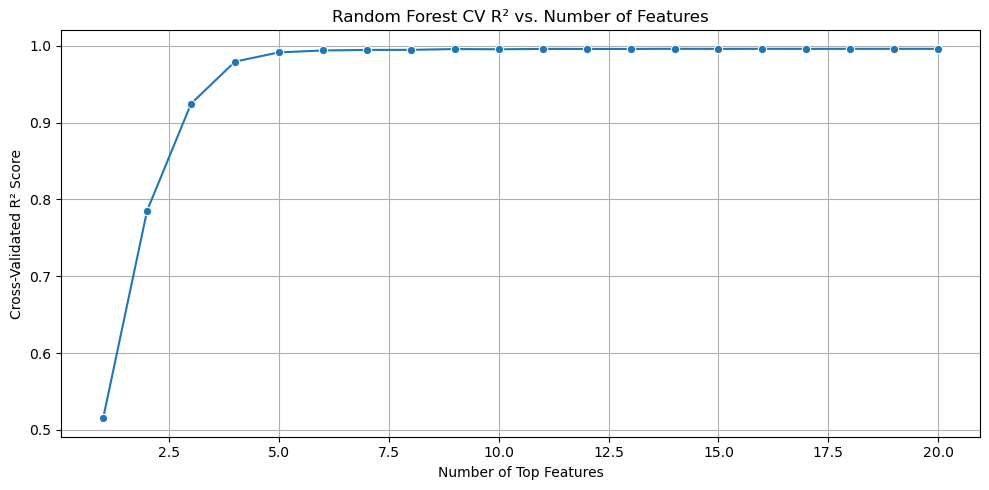

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#Fit model and extract feature importances
rf_full = RandomForestRegressor(random_state=42)
rf_full.fit(X_train_scaled_df, y_train)

importances = rf_full.feature_importances_
feat_imp_df = pd.DataFrame({'Feature': X_train_scaled_df.columns, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False).reset_index(drop=True)

#Perform cross-validation using increasing numbers of features
cv_scores = []
feature_counts = list(range(1, min(21, len(feat_imp_df) + 1)))  # Try top 1 to 20 features

for k in feature_counts:
    top_k_features = feat_imp_df['Feature'].iloc[:k].tolist()
    X_k = X_train_scaled_df[top_k_features]
    scores = cross_val_score(RandomForestRegressor(random_state=42), X_k, y_train, cv=5, scoring='r2')
    cv_scores.append(scores.mean())

#Plot R² vs number of features
plt.figure(figsize=(10, 5))
sns.lineplot(x=feature_counts, y=cv_scores, marker='o')
plt.xlabel('Number of Top Features')
plt.ylabel('Cross-Validated R² Score')
plt.title('Random Forest CV R² vs. Number of Features')
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
# Get range for numerical features
numerical_features = ['plasma glucose', 'blood pressure', 'age', 'bmi']
for feature in numerical_features:
    min_val = X_train_selected[feature].min()
    max_val = X_train_selected[feature].max()
    print(f"{feature} range: {min_val} to {max_val}")

# Get unique values for categorical features
categorical_features = ['chest pain type', 'gender']
for feature in categorical_features:
    unique_vals = X_train_selected[feature].unique()
    print(f"{feature} unique values: {unique_vals}")


plasma glucose range: -1.553483722657333 to 2.1310245626237596
blood pressure range: -2.0724434239028917 to 2.339852322327263
age range: -2.0414317358119605 to 2.7476279067562683
bmi range: -2.335756944679591 to 6.369636489327325
chest pain type unique values: [-0.69249618  1.64833231  1.06312519 -0.10728905  0.47791807]
gender unique values: [-1.54064469  0.78457558 -0.8535273  ... -0.01117415 -1.20461496
  0.31429006]


In [17]:

# To data scaling

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

#Fit initial Random Forest for feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Ensure column names from original data
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

# Select the desired subset of features
selected_features = ['plasma glucose', 'blood pressure', 'age', 'bmi', 'chest pain type', 'gender']
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Fit RandomForestClassifier on selected features
rf_selected = RandomForestClassifier(random_state=42)
rf_selected.fit(X_train_selected, y_train)


RandomForestClassifier(random_state=42)

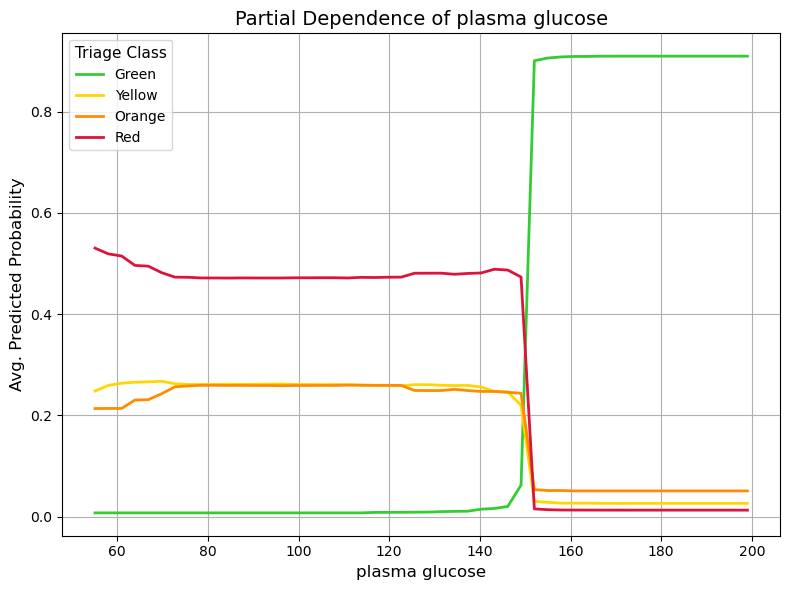

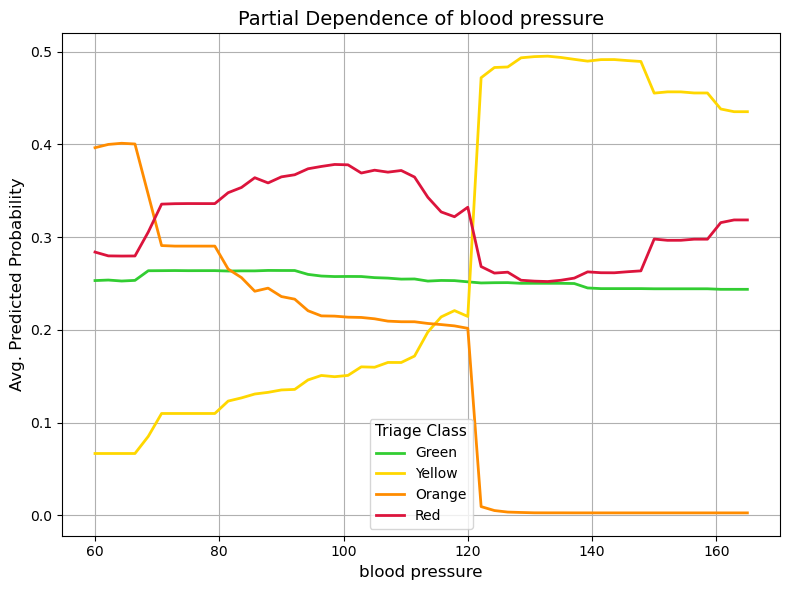

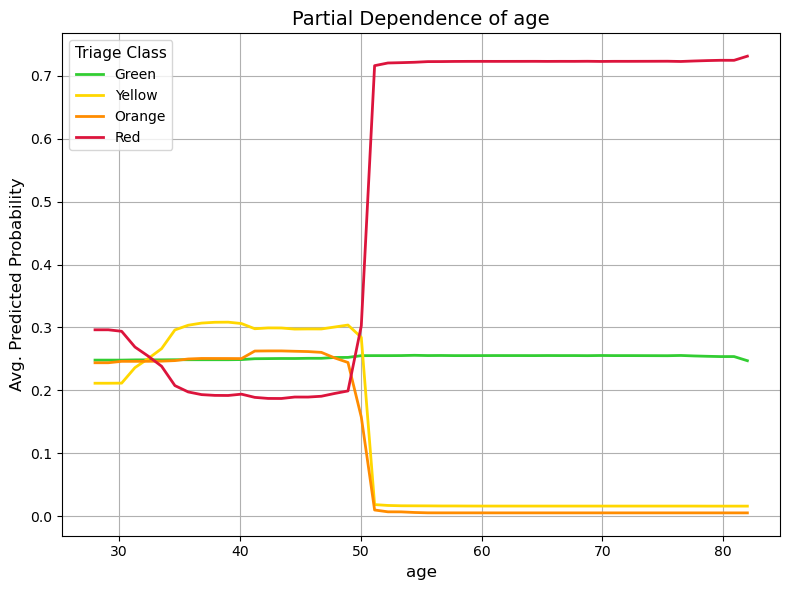

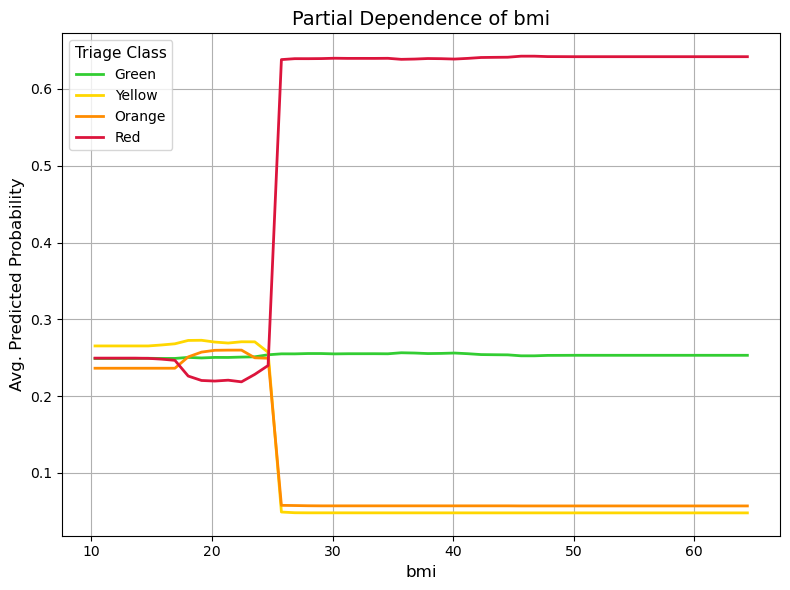

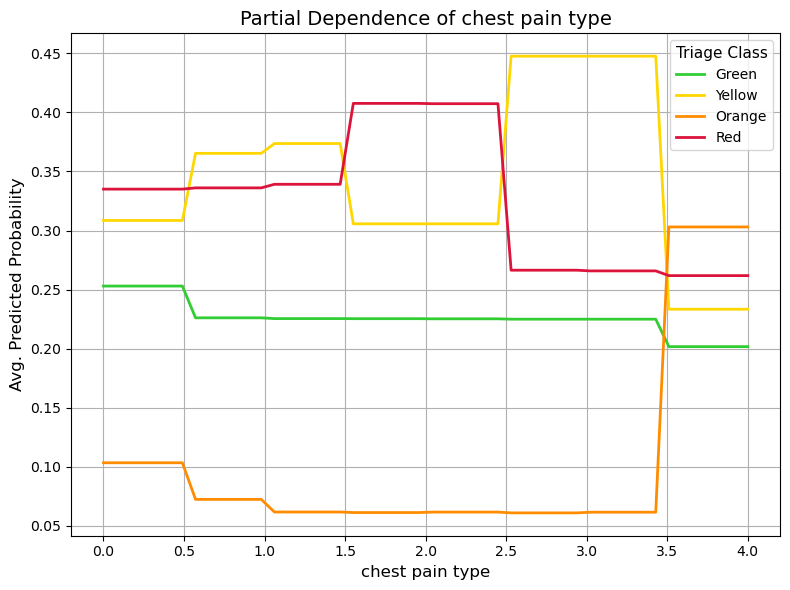

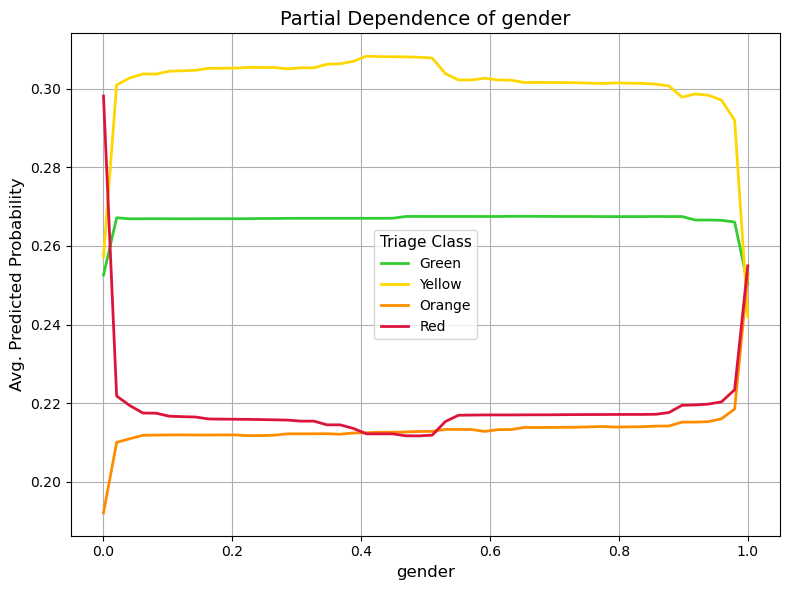

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Features you want PDPs for
features = ['plasma glucose', 'blood pressure', 'age', 'bmi', 'chest pain type', 'gender']

# Map class index to triage color labels
class_label_map = {
    0: 'green',
    1: 'yellow',
    2: 'orange',
    3: 'red'
}

# Color map for plotting
color_map = {
    'green': 'limegreen',
    'yellow': 'gold',
    'orange': 'darkorange',
    'red': 'crimson'
}

# Loop through each feature
for feature in features:
    plt.figure(figsize=(8, 6))
    grid = np.linspace(X_train_selected[feature].min(), X_train_selected[feature].max(), 50)

    for class_idx in range(len(class_label_map)):
        pd_values = []

        for val in grid:
            X_temp =X_train_selected.copy()
            X_temp[feature] = val
            proba = rf_selected.predict_proba(X_temp)[:, class_idx]
            pd_values.append(np.mean(proba))

        label = class_label_map[class_idx]
        plt.plot(
            grid,
            pd_values,
            label=label.capitalize(),
            color=color_map[label],
            linewidth=2
        )

    plt.title(f'Partial Dependence of {feature}', fontsize=14)
    plt.xlabel(feature, fontsize=12)
    plt.ylabel('Avg. Predicted Probability', fontsize=12)
    plt.legend(title='Triage Class', fontsize=10, title_fontsize=11)
    plt.grid(True)
    plt.tight_layout()
    plt.show()





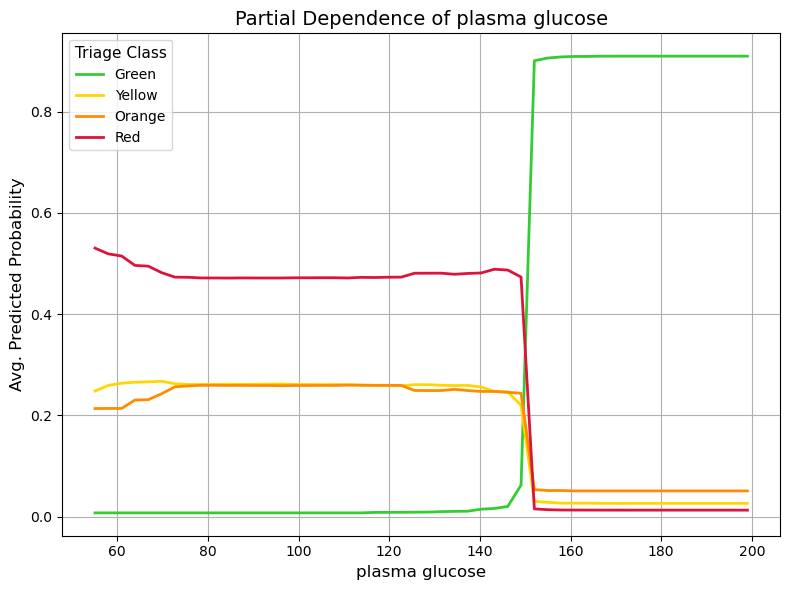

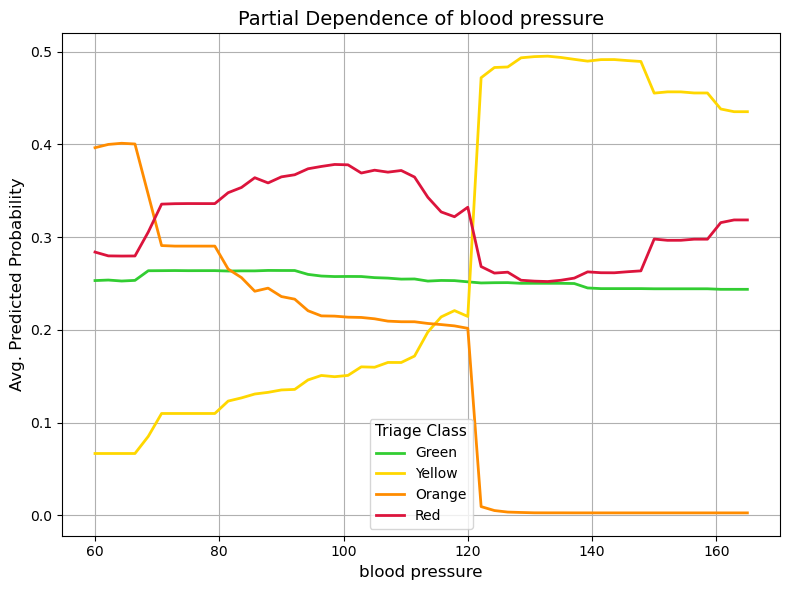

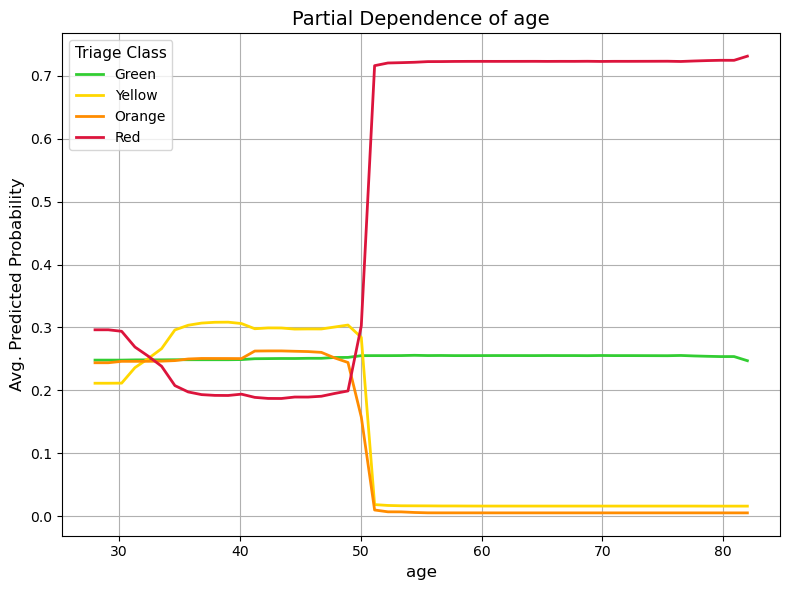

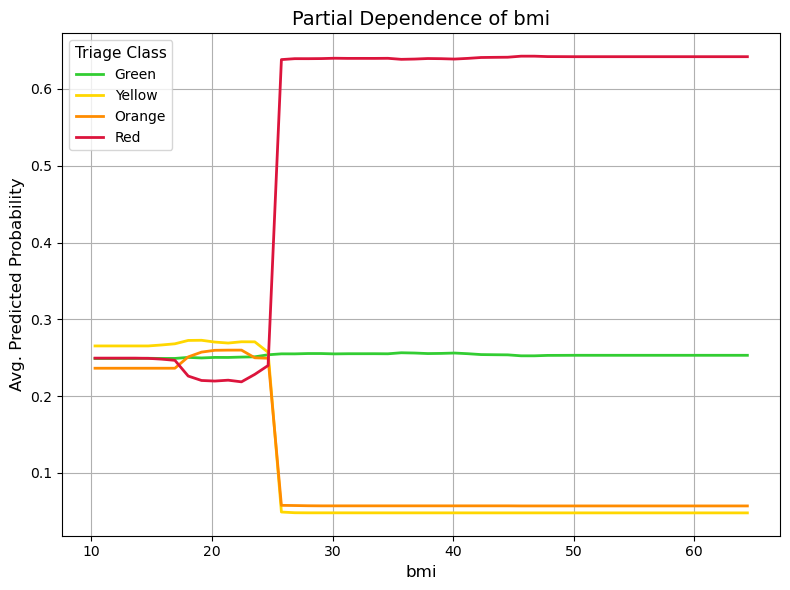

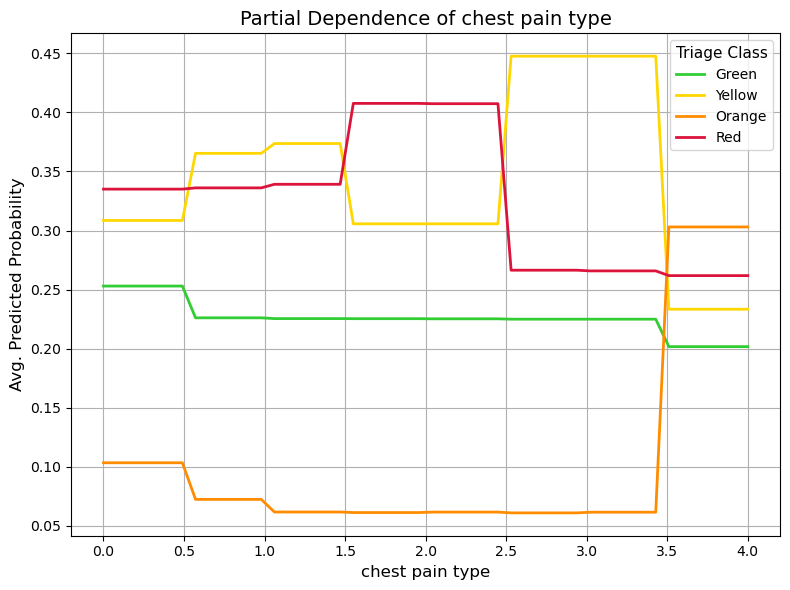

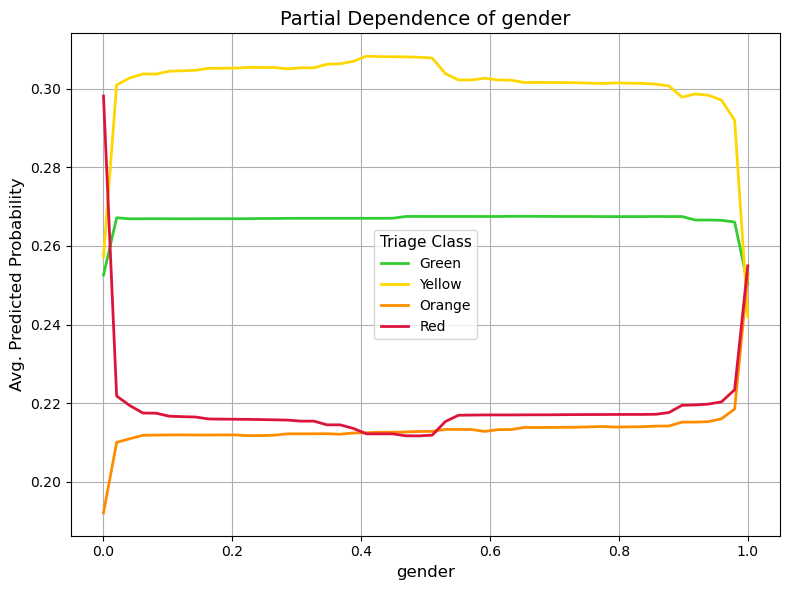

In [20]:
expected_cols = [
    'Sleep_Duration', 'Weekday_Sleep_End', 'Weekend_Sleep_End', 'Screen_Time',
    'Weekend_Sleep_Start', 'Weekday_Sleep_Start', 'Physical_Activity', 'Study_Hours'
]

# Filter and reorder your DataFrame
X_matched = X_train_best[expected_cols]

# Now draw the PDP safely
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

top_features = ['Sleep_Duration', 'Screen_Time', 'Study_Hours']  # or any subset of the 8
fig, ax = plt.subplots(figsize=(12, 4 * len(top_features)))
PartialDependenceDisplay.from_estimator(
    final_rf,
    X_matched,
    features=top_features,
    ax=ax
)
plt.tight_layout()
plt.show()


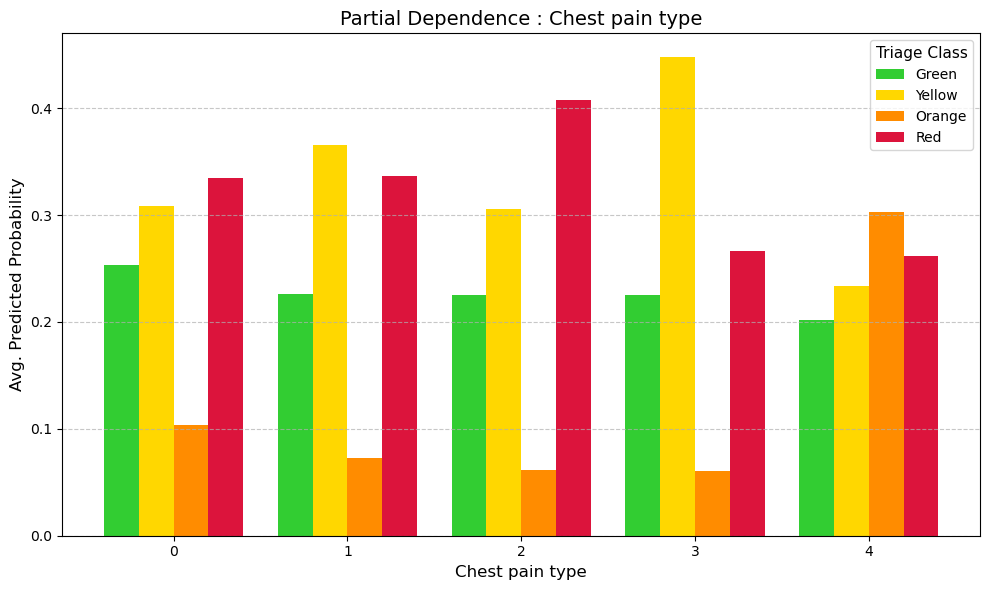

C:\Users\HP\AppData\Local\Temp\ipykernel_20764\3511151779.py:63: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\HP\AppData\Local\Temp\ipykernel_20764\3511151779.py:67: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(filename, dpi=300, bbox_inches='tight')
C:\Users\HP\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


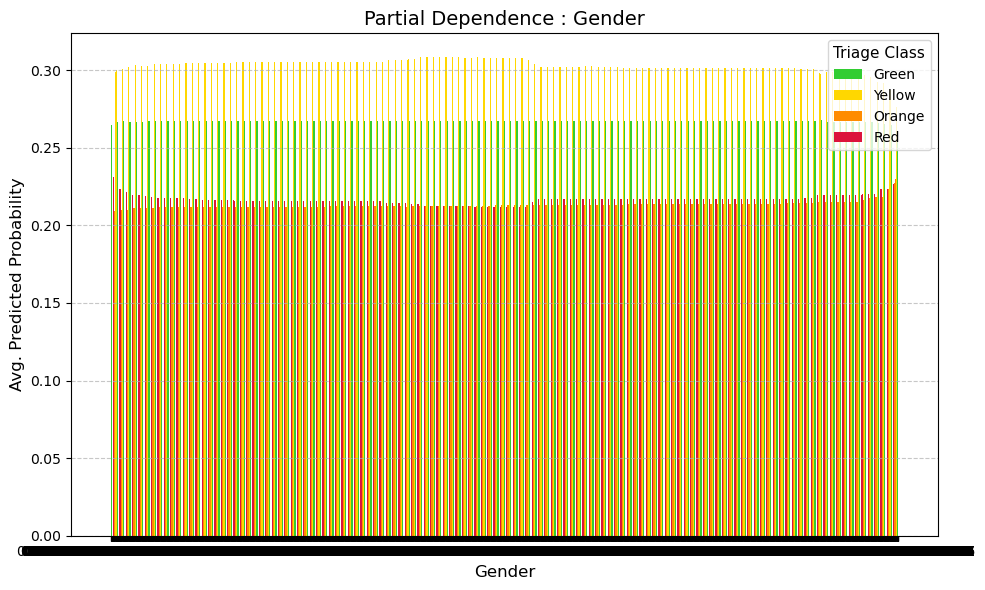

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Define categorical features to plot as bar plots
categorical_features = ['chest pain type', 'gender']

# Map class index to triage color labels
class_label_map = {
    0: 'green',
    1: 'yellow',
    2: 'orange',
    3: 'red'
}

# Color map for plotting
color_map = {
    'green': 'limegreen',
    'yellow': 'gold',
    'orange': 'darkorange',
    'red': 'crimson'
}

for feature in categorical_features:
    plt.figure(figsize=(10, 6))

    # Get unique sorted categories for the feature
    categories = sorted(X_train_selected[feature].unique())

    # Initialize data holder
    pdp_data = {label: [] for label in class_label_map.values()}

    for category in categories:
        X_temp = X_train_selected.copy()
        X_temp[feature] = category  # Set entire column to current category
        proba = rf_selected.predict_proba(X_temp)
        
        for class_idx in range(len(class_label_map)):
            label = class_label_map[class_idx]
            avg_proba = np.mean(proba[:, class_idx])
            pdp_data[label].append(avg_proba)

    # Convert to DataFrame for easy plotting
    pdp_df = pd.DataFrame(pdp_data, index=categories)

    # Plot grouped bar chart
    bar_width = 0.2
    x = np.arange(len(categories))

    for i, label in enumerate(class_label_map.values()):
        plt.bar(x + i * bar_width,
                pdp_df[label],
                width=bar_width,
                label=label.capitalize(),
                color=color_map[label])

    plt.xticks(x + bar_width * 1.5, categories)
    plt.xlabel(feature.capitalize(), fontsize=12)
    plt.ylabel('Avg. Predicted Probability', fontsize=12)
    plt.title(f'Partial Dependence : {feature.capitalize()}', fontsize=14)
    plt.legend(title='Triage Class', fontsize=10, title_fontsize=11)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Save the bar plot
    filename = f'partial_dependence_{feature.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
